In [166]:
import torch
from torch.utils.data import DataLoader
from torch import nn, optim
from torchvision import datasets
import torchvision.transforms as transforms
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.autograd import Variable

In [167]:
def show_img(imgs):
    imgs = torchvision.utils.make_grid(imgs)
    npimgs = imgs.numpy()
    plt.figure(figsize=(8,8))
    plt.imshow(np.transpose(npimgs, (1,2,0)), cmap='Greys_r')
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [168]:
batch_size = 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lr = 0.0002
z_dim = 64
in_dims = 28 * 28 * 1  # 784
num_epochs = 1

In [169]:

dataset = torchvision.datasets.MNIST(root = ("data/"),download = True, transform =transforms.ToTensor())
test_dataset = torchvision.datasets.MNIST(root = ("data/"),download = True,train= False, transform =transforms.ToTensor())

In [170]:
from torch.utils.data.dataset import random_split
val_ratio = 0.2
train_dataset, val_dataset= random_split(dataset,[int((1-val_ratio)*len(dataset)),int((val_ratio)*len(dataset))] )
batch_size = 64
train_loader = DataLoader(dataset, batch_size, shuffle = True, pin_memory = True)
val_loader = DataLoader(test_dataset, batch_size, shuffle = True, pin_memory = True)
test_loader = DataLoader(test_dataset, batch_size, pin_memory = True)

In [171]:
images, labels = next(iter(train_loader))

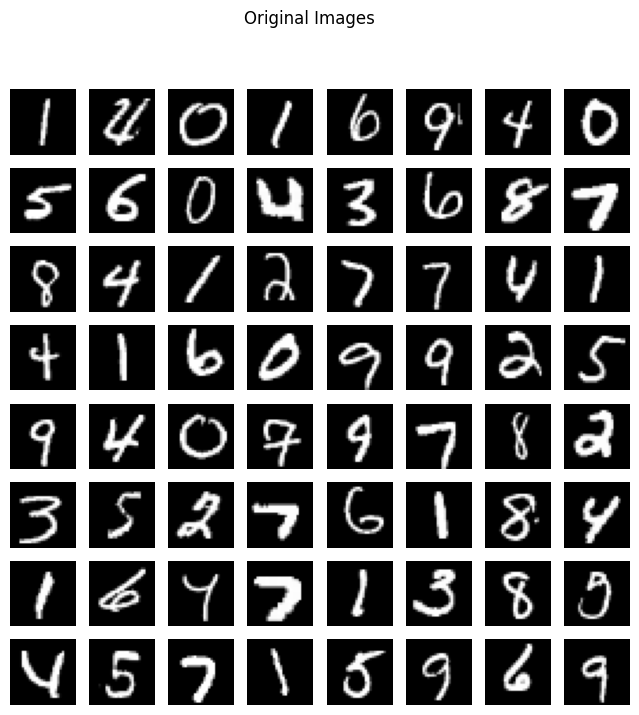

In [172]:
def plot_samples_grid(ds_loader, n_rows=8, n_cols=8, fig_size=8, img_dim=28, title=None):

    f, axarr = plt.subplots(n_rows, n_cols, figsize=(fig_size, fig_size))

    images, labels = next(iter(ds_loader))

    for i, ax in enumerate(axarr.flat):
        ax.imshow(images[i].view(img_dim, img_dim), cmap = 'gray')
        ax.axis('off')

    plt.suptitle(title)
    plt.show()

plot_samples_grid(train_loader, title='Original Images')

In [173]:

class FeatureRecognition(nn.Module):
    def __init__(self, in_dims, num_classes):
        super(FeatureRecognition, self).__init__()
        self.fc1 = nn.Linear(in_dims, 120)  
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim = num_classes)

    def forward(self,x):
        x = self.relu(self.fc1(x))
        
        x = self.relu(self.fc2(x))
        
        x = self.fc3(x)
        
        out = self.softmax(x)
        
        return out
        
    def num_flat_features(self,x):
    
      size=x.size()[1:]
      
      num_features=1
      
      for s in size:
          num_features*=s
      
      return num_features

x, y = next(iter(train_loader))
x.shape
x = x.to(device).view(x.shape[0], 784)
x.shape
y_hat=FeatureRecognition(784,1).forward(x)
print(y_hat[1])
print(y[1])

tensor([0.1073, 0.0895, 0.1060, 0.0940, 0.1081, 0.1055, 0.0978, 0.1018, 0.0996,
        0.0904], grad_fn=<SelectBackward0>)
tensor(8)


In [174]:
model = FeatureRecognition(in_dims, 1).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)
loss_fn = nn.BCELoss(reduction="sum")

In [175]:
class block(nn.Module):
    def __init__(
        self, in_channels, intermediate_channels, identity_downsample=None, stride=1
    ):
        super().__init__()
        self.expansion = 4
        self.conv1 = nn.Conv2d(
            in_channels,
            intermediate_channels,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False,
        )
        self.bn1 = nn.BatchNorm2d(intermediate_channels)
        self.conv2 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False,
        )
        self.bn2 = nn.BatchNorm2d(intermediate_channels)
        self.conv3 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels * self.expansion,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False,
        )
        self.bn3 = nn.BatchNorm2d(intermediate_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        self.stride = stride

    def forward(self, x):
        identity = x.clone()

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x
class ResNet(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(
            image_channels, 64, kernel_size=7, stride=2, padding=3, bias=False
        )
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Essentially the entire ResNet architecture are in these 4 lines below
        self.layer1 = self._make_layer(
            block, layers[0], intermediate_channels=64, stride=1
        )
        self.layer2 = self._make_layer(
            block, layers[1], intermediate_channels=128, stride=2
        )
        self.layer3 = self._make_layer(
            block, layers[2], intermediate_channels=256, stride=2
        )
        self.layer4 = self._make_layer(
            block, layers[3], intermediate_channels=512, stride=2
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)
        self.softmax = nn.Softmax(dim = -1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        out = self.softmax(x)
        # max_out = max(out)
        return out

    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []

        # Either if we half the input space for ex, 56x56 -> 28x28 (stride=2), or channels changes
        # we need to adapt the Identity (skip connection) so it will be able to be added
        # to the layer that's ahead
        if stride != 1 or self.in_channels != intermediate_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    intermediate_channels * 4,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(intermediate_channels * 4),
            )

        layers.append(
            block(self.in_channels, intermediate_channels, identity_downsample, stride)
        )

        # The expansion size is always 4 for ResNet 50,101,152
        self.in_channels = intermediate_channels * 4

        # For example for first resnet layer: 256 will be mapped to 64 as intermediate layer,
        # then finally back to 256. Hence no identity downsample is needed, since stride = 1,
        # and also same amount of channels.
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))

        return nn.Sequential(*layers)

In [184]:


def ResNet50(img_channel=3, num_classes=10):
    return ResNet(block, [3, 4, 6, 3], img_channel, num_classes)


def ResNet101(img_channel=3, num_classes=10):
    return ResNet(block, [3, 4, 23, 3], img_channel, num_classes)


def ResNet152(img_channel=3, num_classes=10):
    return ResNet(block, [3, 8, 36, 3], img_channel, num_classes)


def one_hot_vector(y_predict):
    results = []
    for predict in y_predict:        
        condition = (predict == np.max(predict))
        y_pred = np.where(condition, 1  ,  predict*0 ) 
        results.append(y_pred)
    return results
def one_hot_values(y_predict):
    results = []
    for predict in y_predict:
        condition = (predict == np.max(predict))
        y_pred = np.where(condition, 1  ,  predict*0 ) 
        for i in range(10):
            if y_pred[i] == 1:
                y_pred[i] = i
        results.append(y_pred)
    return results 


BATCH_SIZE = 64
net = ResNet101(img_channel=1, num_classes=10).to(device)
x, y = next(iter(train_loader))
print(x.shape)
# One-hot Vector
y_predict_vector = one_hot_vector(net(x).to(device).detach().numpy())
y_true = nn.functional.one_hot(y, num_classes=10)
y_hat_vector = torch.Tensor(y_predict_vector)
print(y_hat_vector.size())
print(y_true.size())
# Value
y_true = nn.functional.one_hot(y, num_classes=10)
y_predict = net(x).to(device).detach().numpy()
y_hat = torch.Tensor(np.array([np.max(one_hot_values(y_predict), axis=1)], dtype= 'uint8').T).reshape(64)
print(y_hat.size())
print(y.size())
#  Khong dung duoc one hot values

torch.Size([64, 1, 28, 28])
torch.Size([64, 10])
torch.Size([64, 10])
torch.Size([64])
torch.Size([64])


In [191]:
print(y_hat_vector[10], y_true[10])

tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]) tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 0])


In [190]:
print(y_hat[10], y[10])

tensor(6.) tensor(3)


In [179]:
loss = loss_fn(y_hat_vector.float(), y_true.float()) / BATCH_SIZE
print(loss)

tensor(175.)


In [ ]:
for epoch in range(num_epochs):
    for i, (x, _) in tqdm(enumerate(train_loader)):
        x = x.to(device)
        if i % 32 == 0:
            print(x.shape[0])
        net = ResNet101(img_channel=1, num_classes=10).to(device)
        y_predict = net(x).to(device)
        y_hat = torch.Tensor(np.array([np.max(y_predict.detach().numpy(), axis=1)]).T).reshape(x.shape[0])
        # print(y_hat.shape)
        
        # Loss
        loss = loss_fn(y_hat.float(), y.float()) // batch_size
        loss.requires_grad = True
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print("epoch: " + str(epoch+1))
    print("loss: ", loss)